In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import pointbiserialr
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [232]:
df = pd.read_csv('churn_data/train.csv', sep = ';')

In [233]:
df.HasCrCard = df.HasCrCard.astype(str)
df.Exited = df.Exited.astype(str)
df.IsActiveMember = df.IsActiveMember.astype(str)

In [234]:
# df.drop_duplicates(subset=['CustomerId'], inplace = True)

In [235]:
df.drop(columns = ['id', 'CustomerId','Surname'], inplace = True)

In [236]:
# Getting dataset dimensions and data types
data_overview = {
    "Number of Rows": df.shape[0],
    "Number of Columns": df.shape[1],
    "Data Types": df.dtypes.value_counts()
}
data_overview

{'Number of Rows': 165034,
 'Number of Columns': 11,
 'Data Types': object     5
 int64      3
 float64    3
 Name: count, dtype: int64}

In [237]:
# Identifying columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Calculating the percentage of missing values for each column
missing_percentage = (missing_values / df.shape[0]) * 100

missing_data = pd.DataFrame({"Missing Values": missing_values, "Percentage (%)": missing_percentage})

missing_data

Missing Values  Percentage (%)
Balance                      91        0.055140
EstimatedSalary              38        0.023026

In [238]:
# Getting summary statistics for the numeric columns
summary_statistics = df.describe().transpose()

summary_statistics

count           mean           std     min       25%  \
CreditScore      165034.0     656.454373     80.103340  350.00    597.00   
Age              165034.0      38.125888      8.867205   18.00     32.00   
Tenure           165034.0       5.020353      2.806159    0.00      3.00   
Balance          164943.0   55482.814921  62820.109302    0.00      0.00   
NumOfProducts    165034.0       1.554455      0.547154    1.00      1.00   
EstimatedSalary  164996.0  112571.416570  50292.312539   11.58  74637.57   

                        50%        75%        max  
CreditScore         659.000     710.00     850.00  
Age                  37.000      42.00      92.00  
Tenure                5.000       7.00      10.00  
Balance               0.000  119948.09  250898.09  
NumOfProducts         2.000       2.00       4.00  
EstimatedSalary  117946.715  155068.33  199992.48

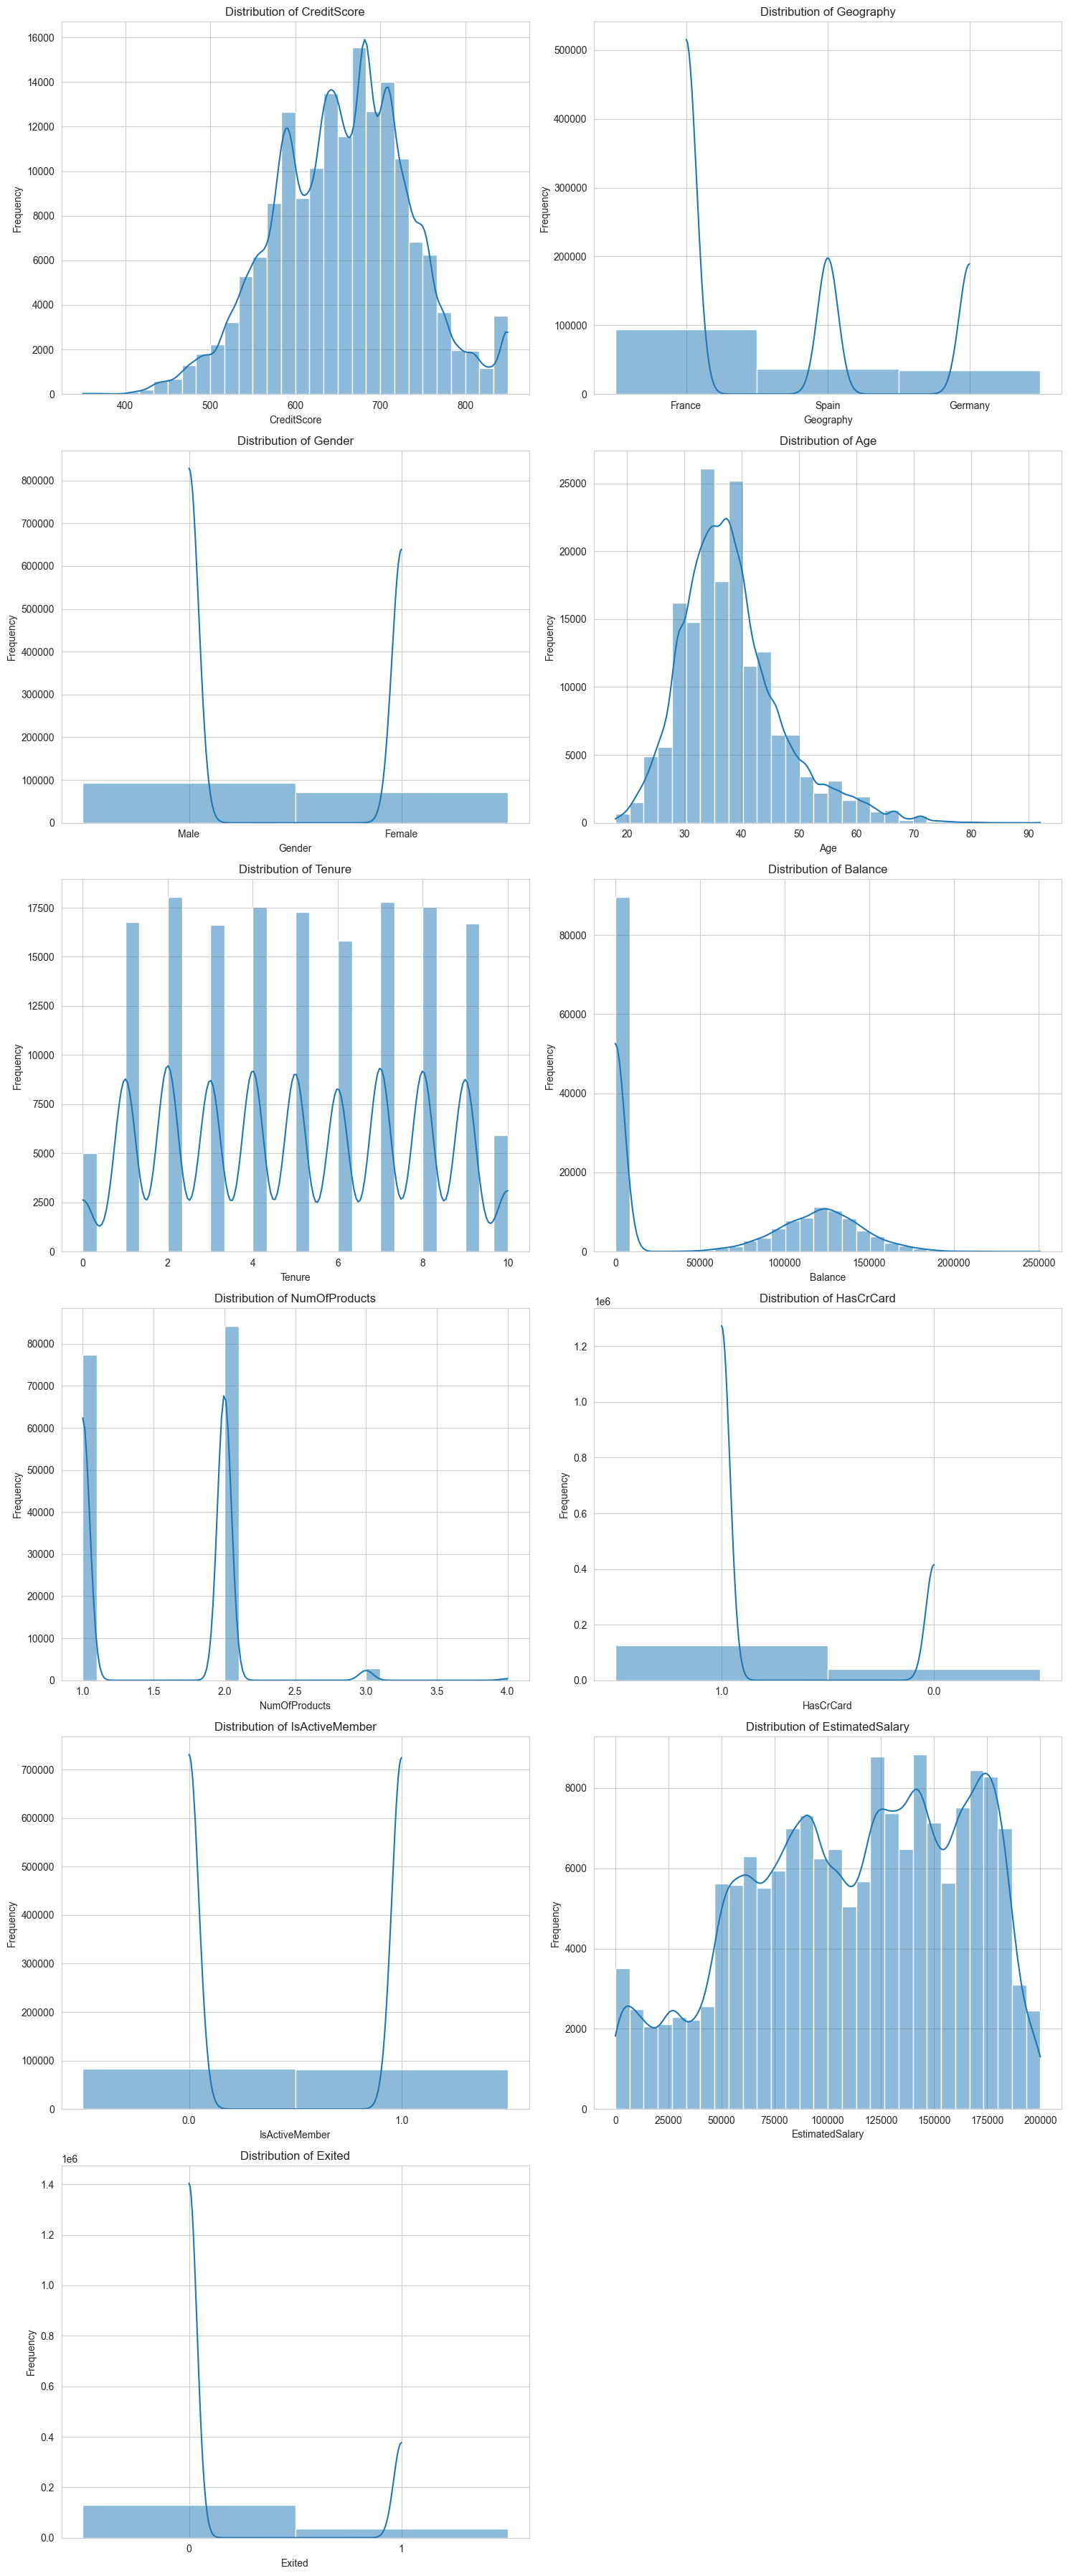

In [239]:
sns.set_style("whitegrid")

variables_to_plot = df.columns
num_vars = len(variables_to_plot)
num_rows = (num_vars + 1) // 2  # Calculate number of rows needed for subplots

plt.figure(figsize=(15, 6 * num_rows))  # Adjust the figure size based on the number of rows

for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(num_rows, 2, i)  # Adjust the subplot parameters
    sns.histplot(df[var], kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

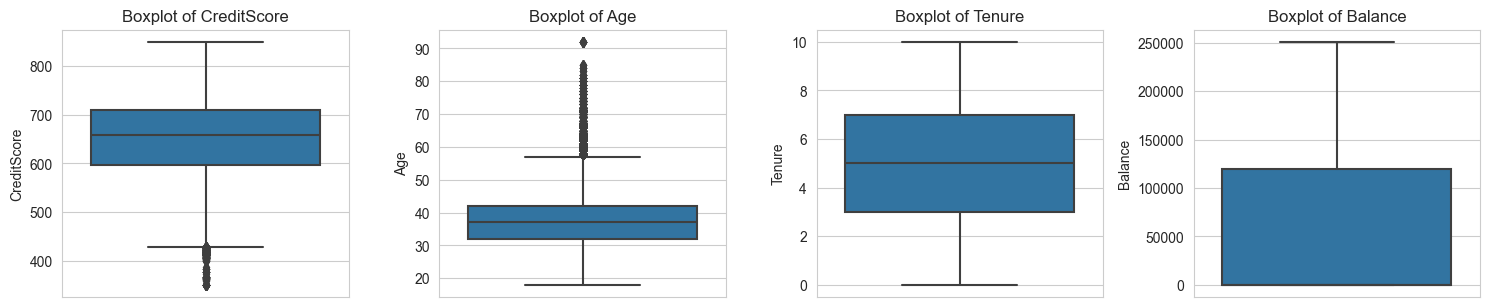

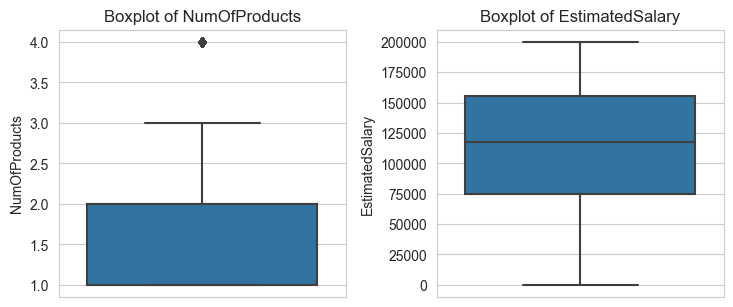

In [240]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Splitting the numeric columns into batches for visualization
batch_size = 4
num_batches = len(numeric_columns) // batch_size + (1 if len(numeric_columns) % batch_size else 0)


for batch in range(num_batches):
    start_index = batch * batch_size
    end_index = start_index + batch_size
    columns_batch = numeric_columns[start_index:end_index]
    
    plt.figure(figsize=(15, 6))
    
    for i, col in enumerate(columns_batch, 1):
        plt.subplot(2, 4, i)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
    
    plt.tight_layout()
    plt.show()

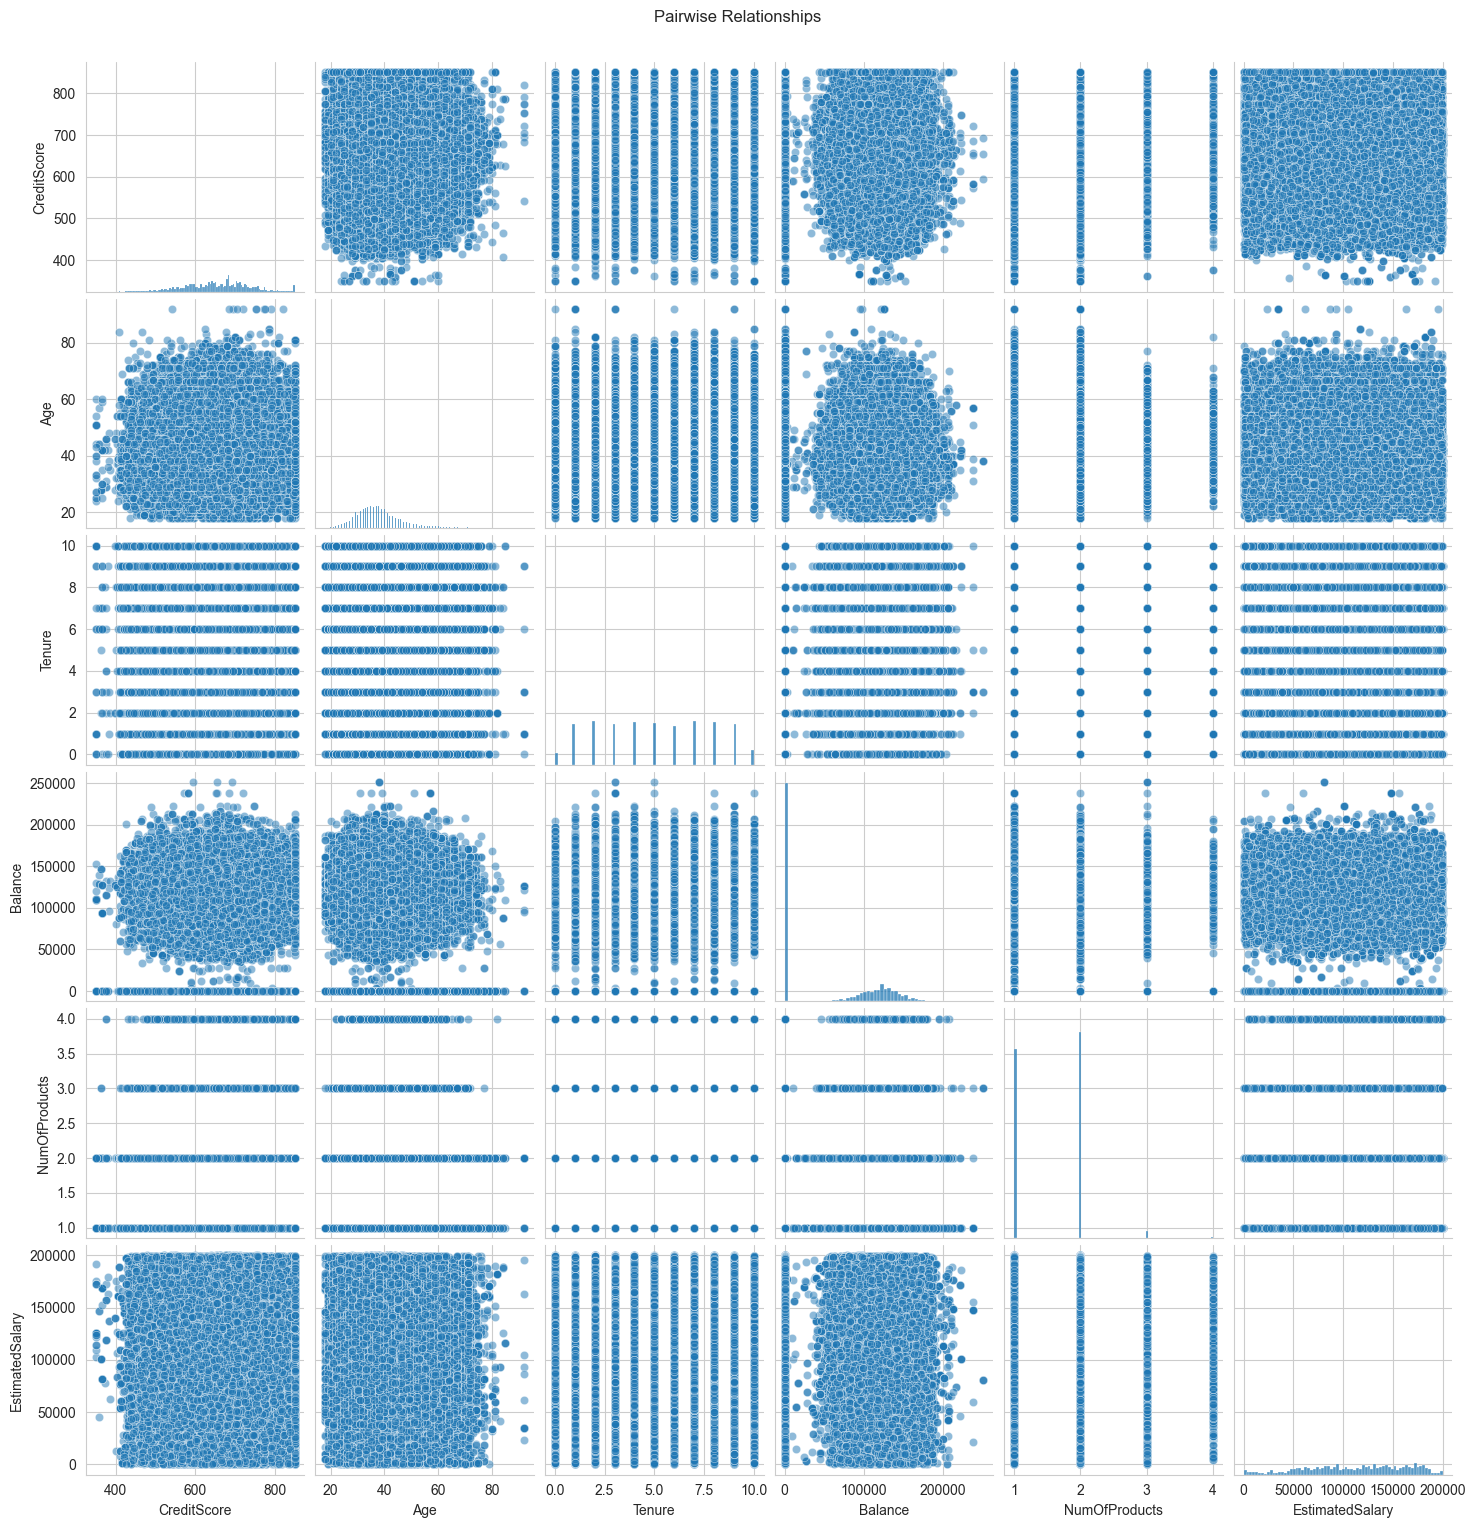

In [241]:
selected_columns = df.columns

sns.pairplot(df[selected_columns], plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

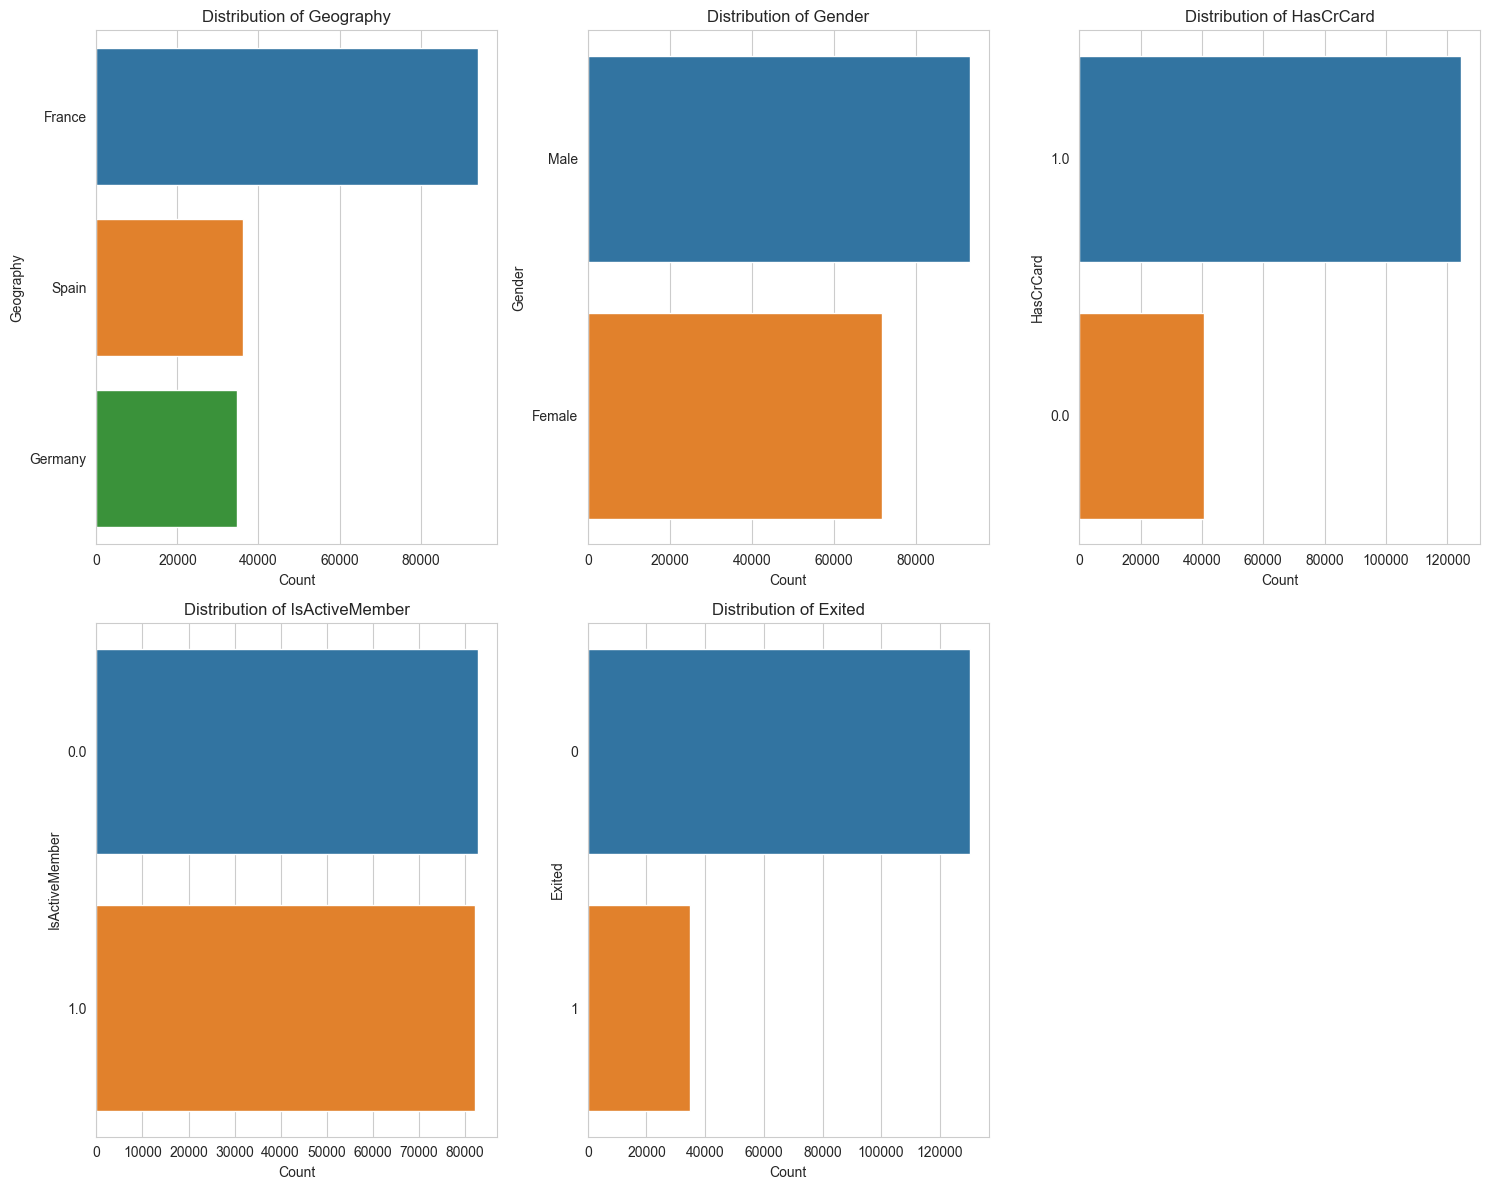

In [242]:
categorical_columns = df.select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 12))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

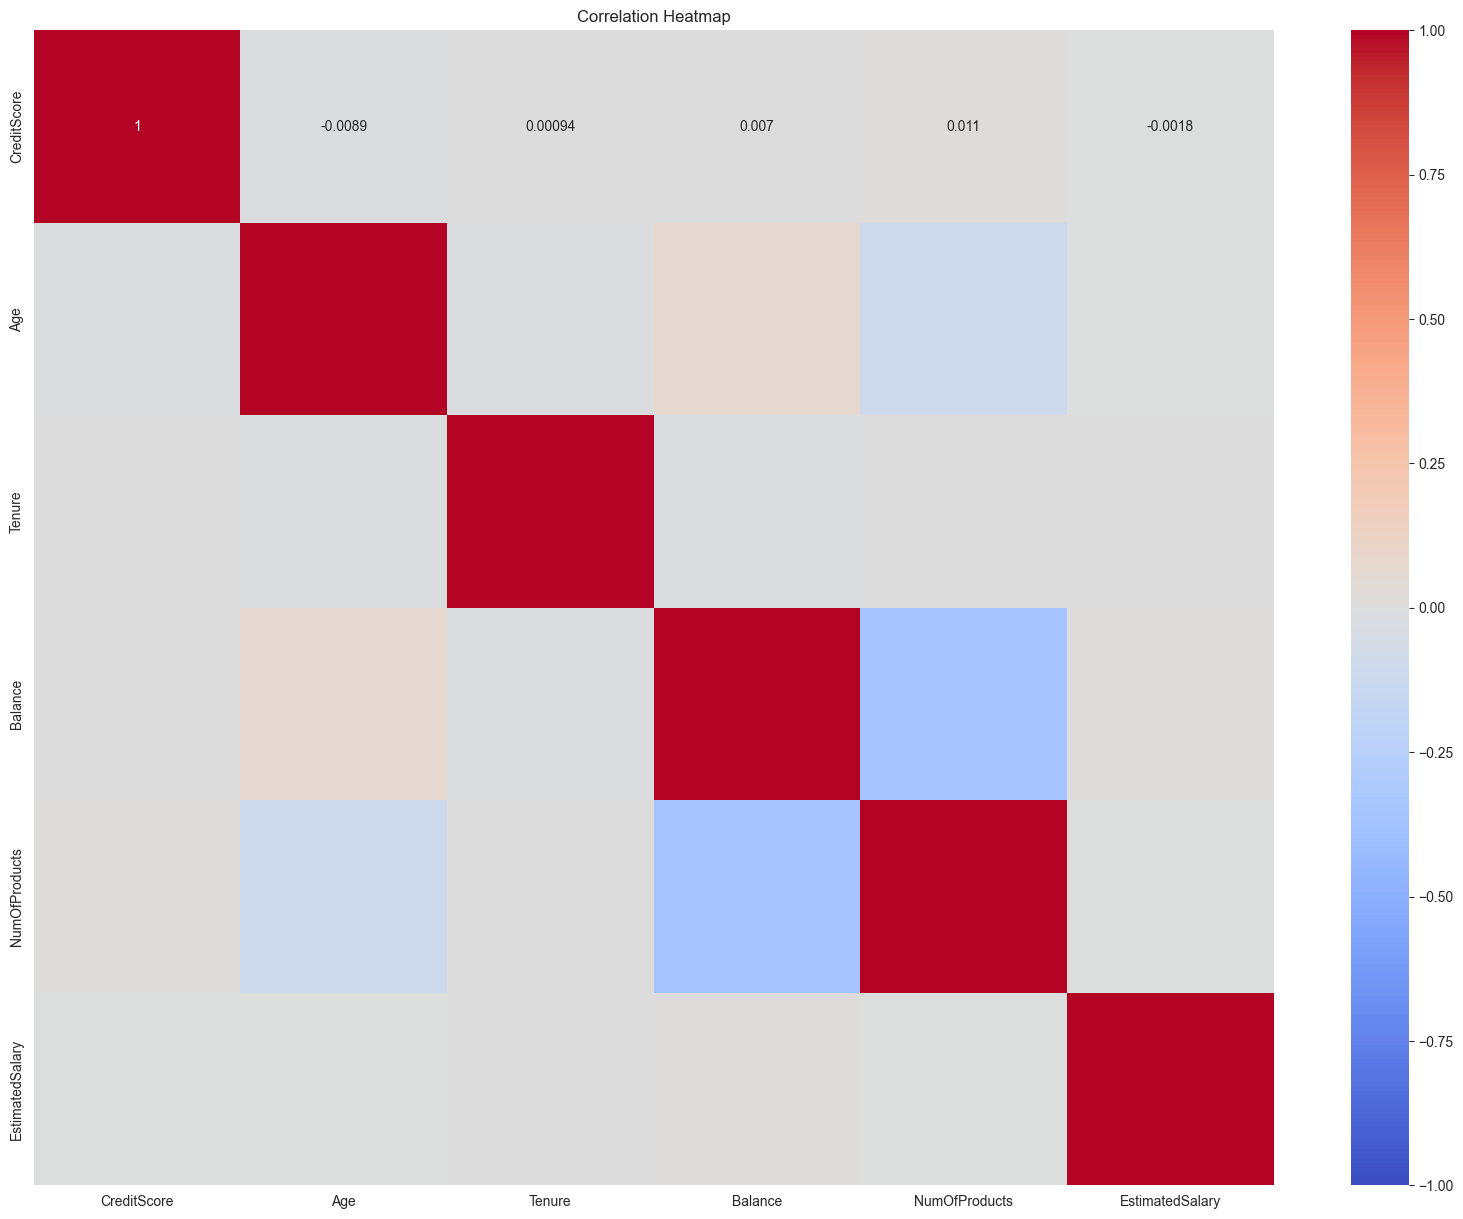

In [243]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

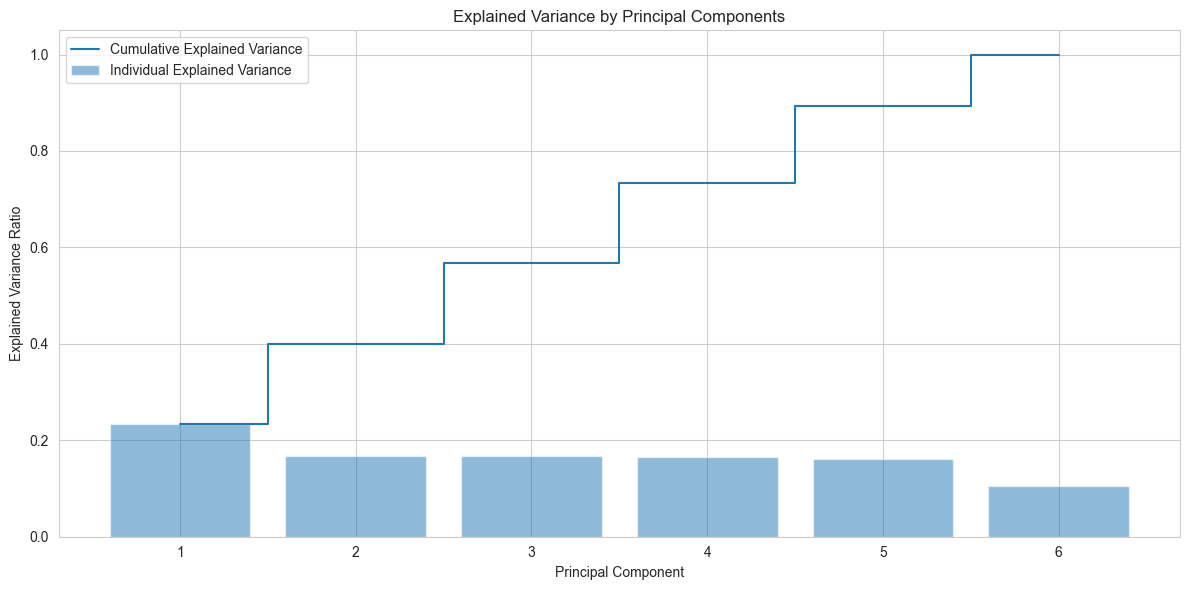

In [244]:
# Scaling the numeric data
scaled_data = StandardScaler().fit_transform(df[numeric_columns].dropna())

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

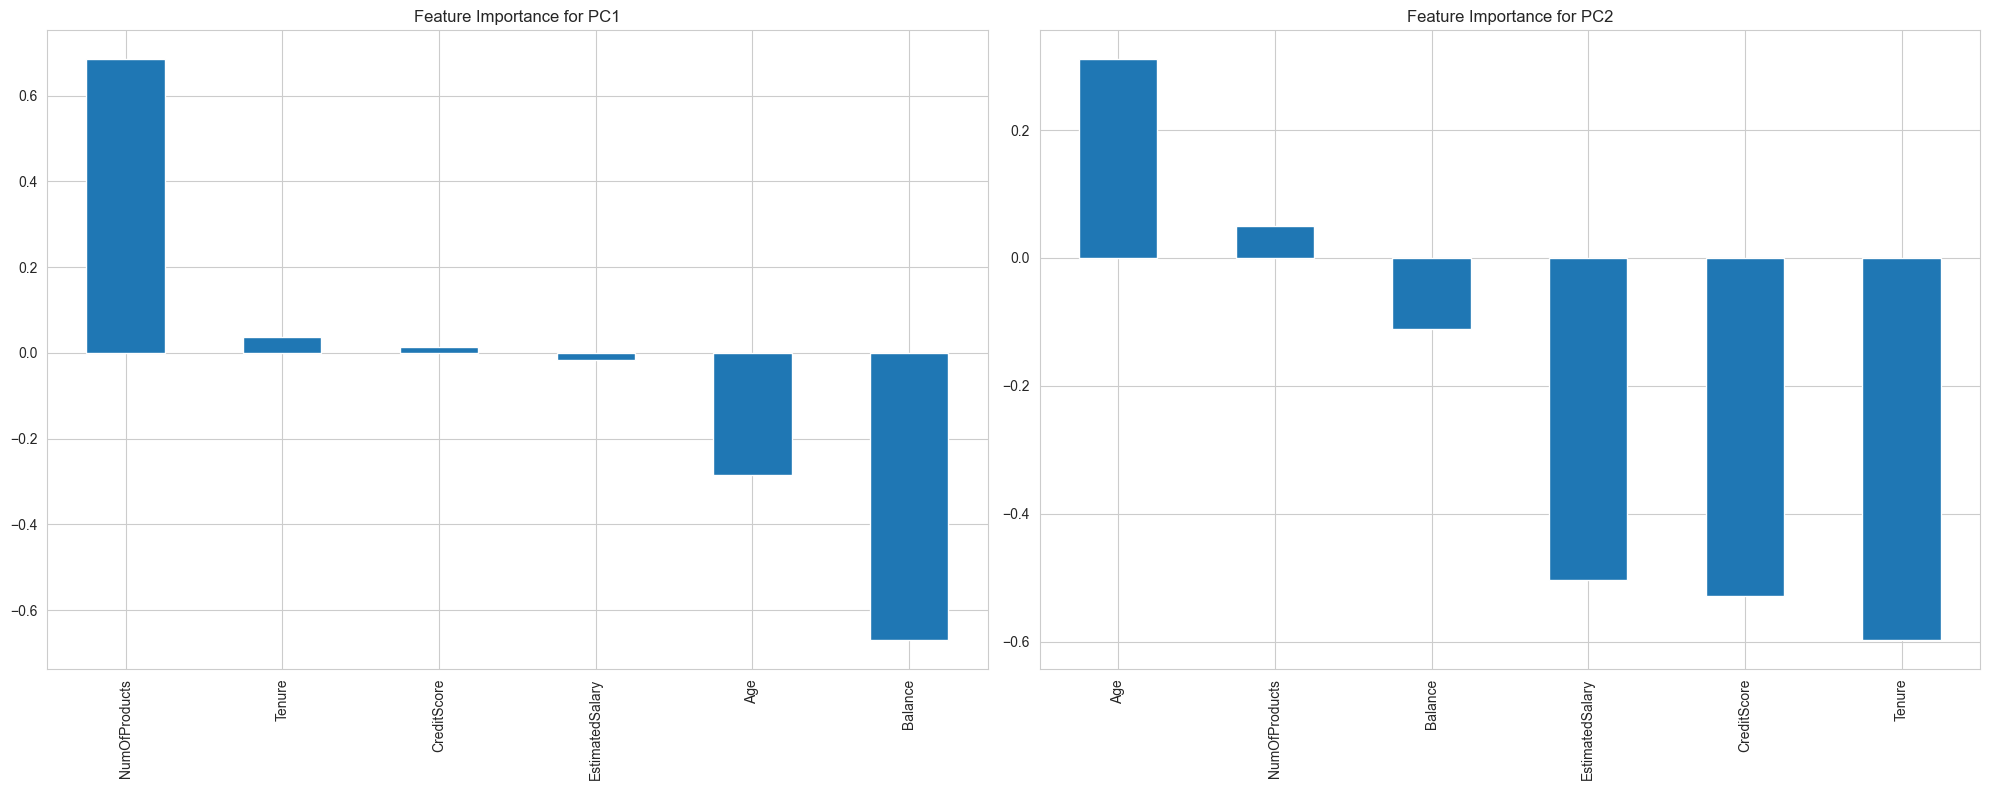

In [245]:
pca = PCA(n_components=2)  # Considering the first 10 principal components for analysis
principal_components = pca.fit_transform(scaled_data)

feature_importance = pd.DataFrame(pca.components_, columns=df[numeric_columns].columns, index=[f"PC{i+1}" for i in range(2)])

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PC1
feature_importance.iloc[0].sort_values(ascending=False).head(10).plot(kind='bar', ax=axes[0], title="Feature Importance for PC1")

# PC2
feature_importance.iloc[1].sort_values(ascending=False).head(10).plot(kind='bar', ax=axes[1], title="Feature Importance for PC2")

plt.tight_layout()
plt.show()

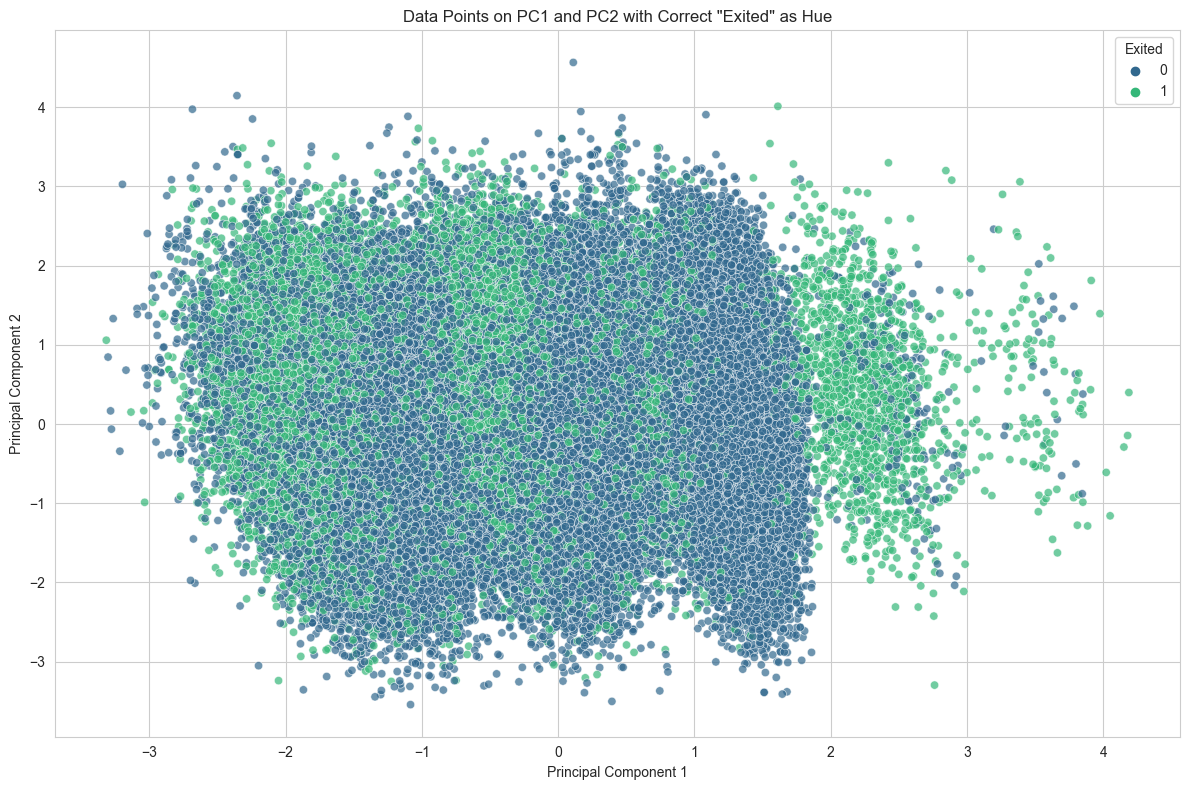

In [246]:
pc1_values = principal_components[:, 0]
pc2_values = principal_components[:, 1]

# Filtering the data frame based on rows retained after dropping missing values
filtered_df = df.dropna(subset=numeric_columns)

# Extracting the correct 'Exited' values
correct_target = filtered_df['Exited']

# Plotting the data points on PC1 and PC2 with the correct 'Exited' as hue
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pc1_values, y=pc2_values, hue=correct_target, alpha=0.7, palette="viridis")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Points on PC1 and PC2 with Correct "Exited" as Hue')
plt.grid(True)
plt.tight_layout()
plt.show()

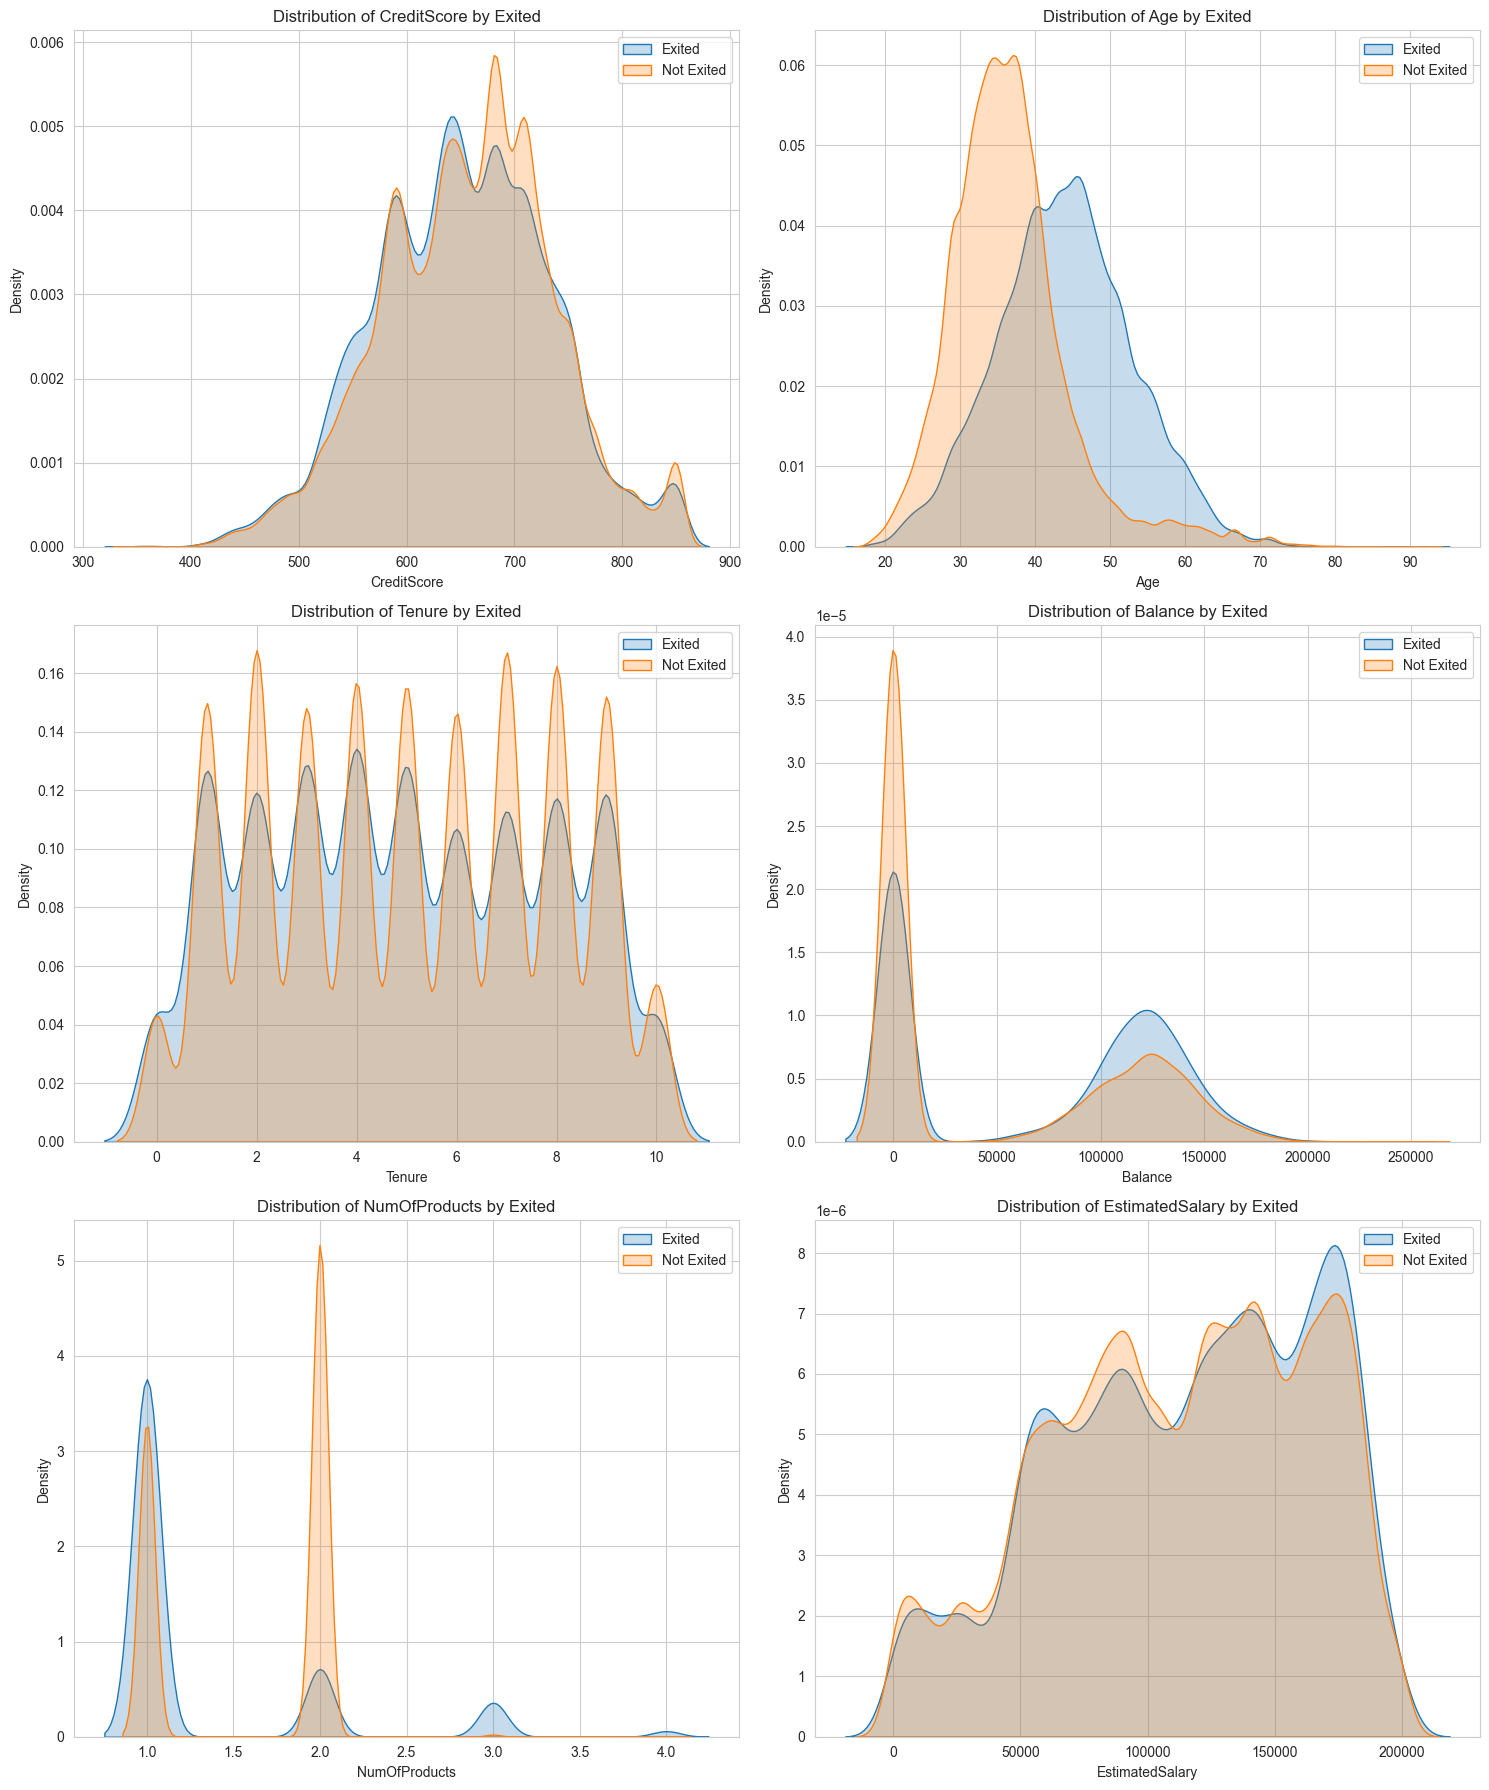

In [247]:
selected_numerical = numeric_columns
num_cols = len(selected_numerical)
num_rows = (num_cols + 1) // 2

plt.figure(figsize=(15, 6 * num_rows))

for i, col in enumerate(selected_numerical, 1):
    plt.subplot(num_rows, 2, i)
    sns.kdeplot(df[df['Exited'] == '1'][col], label='Exited', shade=True)
    sns.kdeplot(df[df['Exited'] == '0'][col], label='Not Exited', shade=True)
    plt.title(f'Distribution of {col} by Exited')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

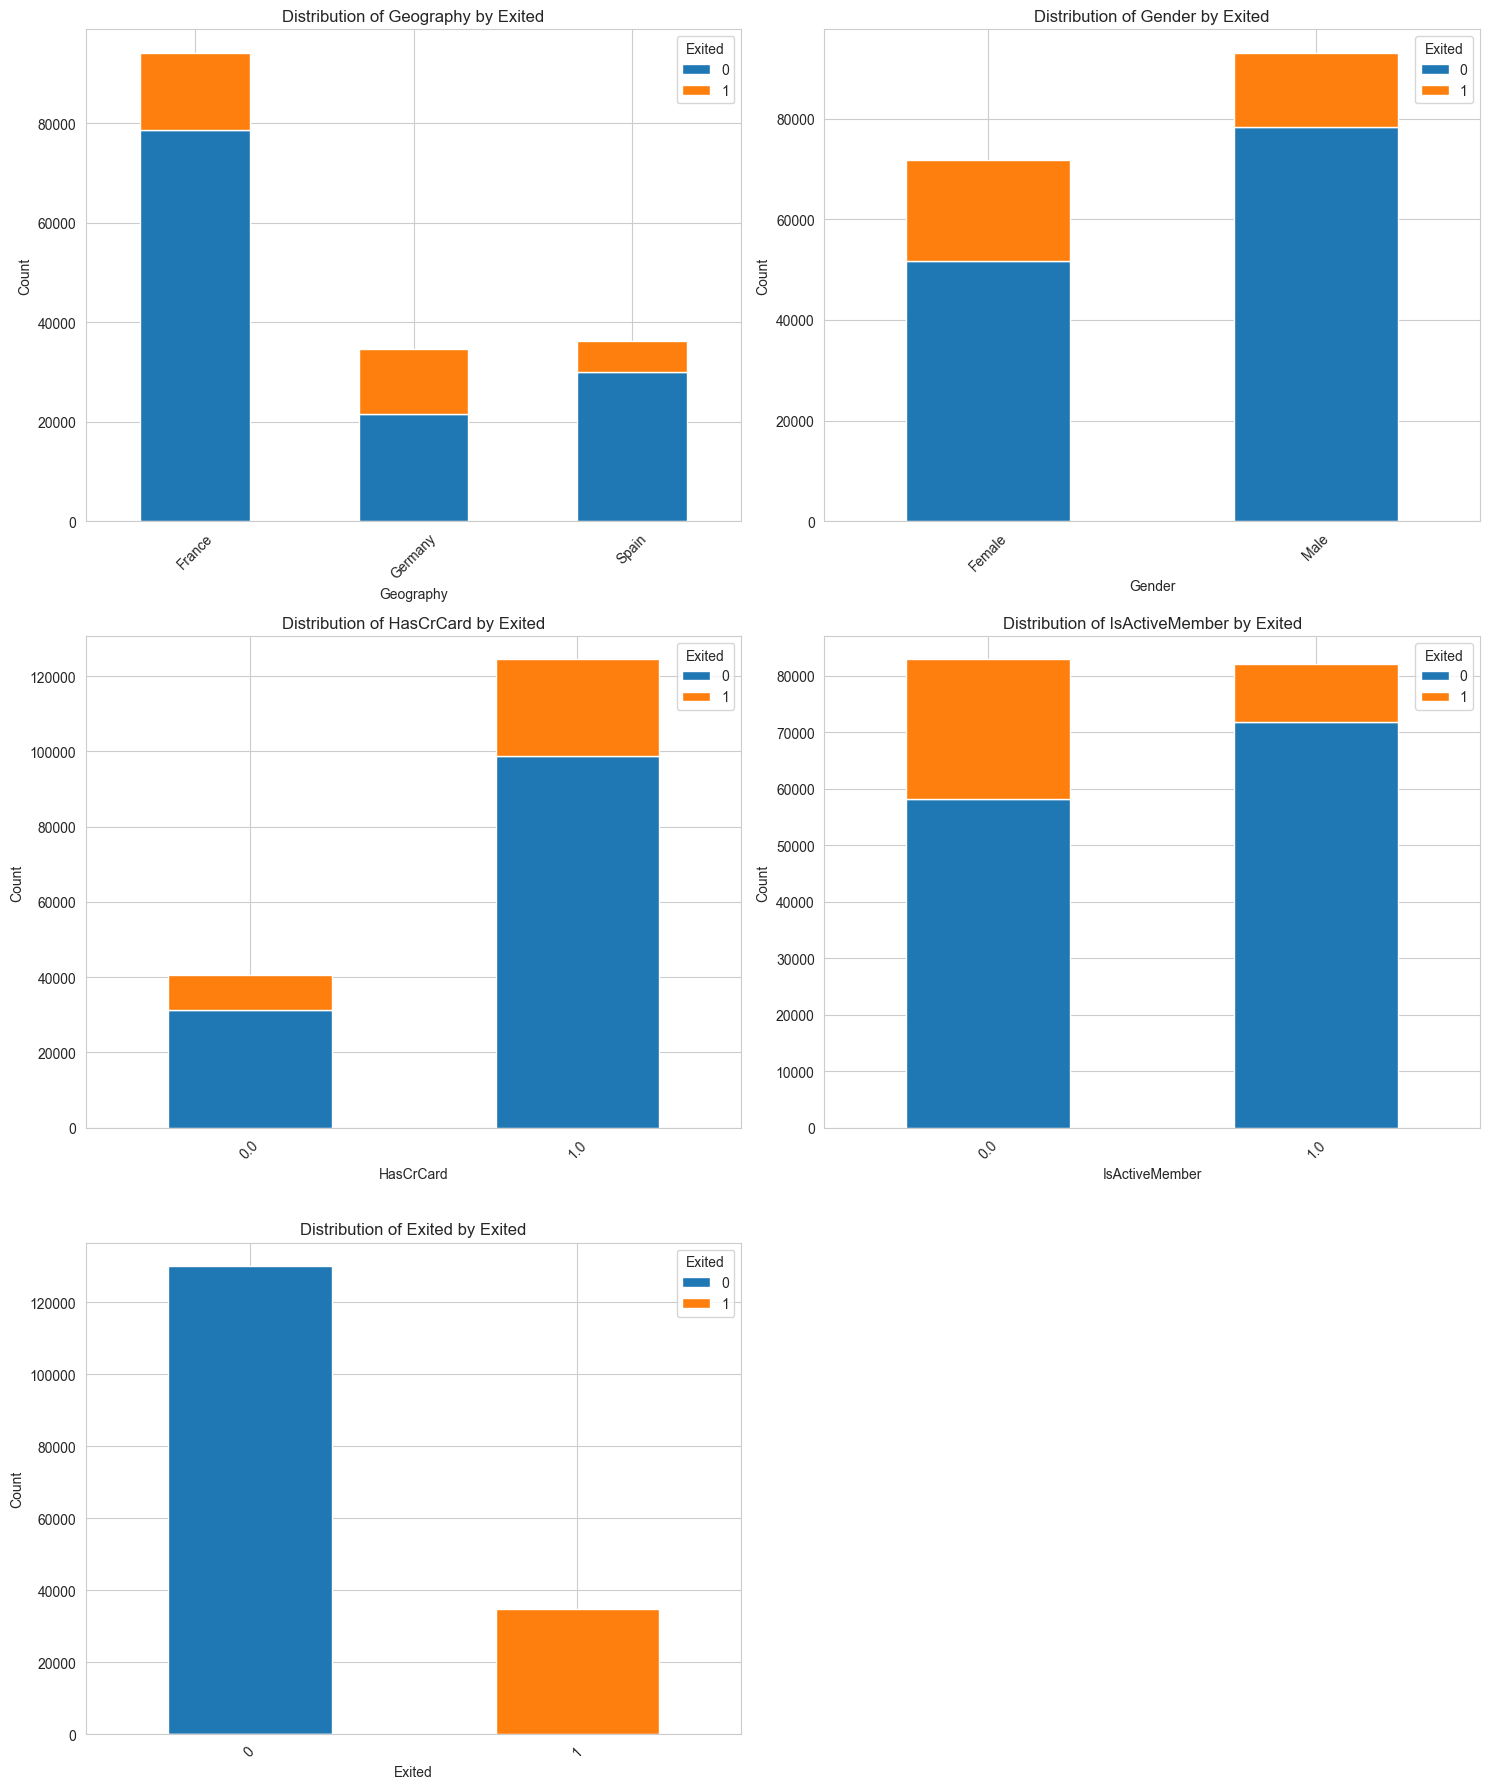

In [248]:
selected_categorical_bivariate = categorical_columns
num_cols = len(selected_categorical_bivariate)
num_rows = (num_cols + 1) // 2

plt.figure(figsize=(15, 6 * num_rows))

for i, col in enumerate(selected_categorical_bivariate, 1):
    plt.subplot(num_rows, 2, i)
    ct = pd.crosstab(df[col], df['Exited'])
    ct.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Distribution of {col} by Exited')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Exited')

plt.tight_layout()
plt.show()


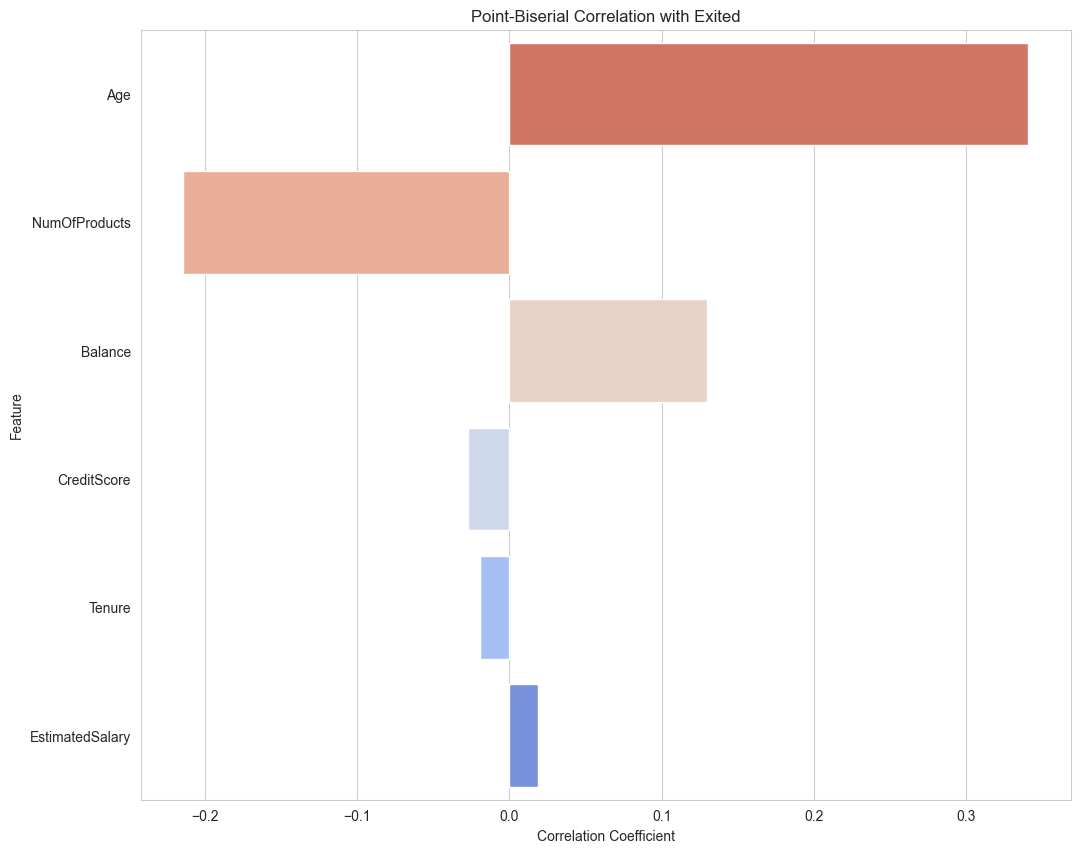

In [249]:
df.Exited= df.Exited.astype(int)

# Calculate point-biserial correlation for numerical features with the target variable
correlations = []
for col in numeric_columns:
    if df[col].notna().sum() > 0:  # Check for non-NaN values
        correlation, _ = pointbiserialr(df[col].fillna(0), df['Exited'])
        correlations.append((col, correlation))

# Sort correlations by absolute value
sorted_correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Visualize the correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=[x[1] for x in sorted_correlations], y=[x[0] for x in sorted_correlations], palette="coolwarm_r")
plt.title('Point-Biserial Correlation with Exited')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()

In [250]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [251]:
categorical_columns = categorical_columns.drop('Exited')

In [252]:
preprocessor = ColumnTransformer(
        transformers=[
            ('rest', StandardScaler(), numeric_columns),
            ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_columns)
            ], verbose_feature_names_out=False)
temp = df['Exited']
df_scaled = preprocessor.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns = preprocessor.get_feature_names_out()).reset_index(drop=True)
df_scaled = pd.concat([df_scaled, temp], axis = 1)

In [253]:
X = df_scaled.drop(columns = ['Exited'])
y = df_scaled['Exited']

In [254]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_train, y_train = ros.fit_resample(X_train, y_train)

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)

In [255]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.851031599357712
Precision: 0.6562404170499847
Recall: 0.6153846153846154
